# Perform CNN using Keras for 13x classes over AWS


In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator

from PIL import ImageFile
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import itertools
import h5py


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Functions for lots later

In [2]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(16,16), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Image preparation

In [4]:
train_path = 'dataset/training_set'
valid_path = 'dataset/validation_set'
test_path = 'dataset/test_set'

In [5]:
# Define batches
# ImageDataGenerator() is a keras object which generates batches of tensor image data.
# flow_from_directory is where you tell keras where is your images, and their labels.
# flow_from_directory also turns the labels to one-hot-encoded based. chopper=[0,0,1,0...0], clock=[1,0,0...0] 
# In this case we assigned 128x128 only because it yields a better result.
# If using VGG16, we had to change to 224x224, because VGG16 takes this size as inputs.
# If you are working on different classes such as xray images, a different size may be apply to achieve better result.
# This is a trail and error thing.

train_batches = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True).flow_from_directory(train_path, target_size = (128, 128), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                                   batch_size = 20)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, target_size = (128, 128), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                         batch_size = 20)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (128, 128), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                         batch_size = 130)

Found 14970 images belonging to 13 classes.
Found 2593 images belonging to 13 classes.
Found 130 images belonging to 13 classes.


We put batch size 20. This is the number of images we will be grabbing for iteration.

In [6]:
# Every time we run this, a next sets of 20 images.
imgs, labels = next(train_batches)

In [7]:
# below are 1x batch, here are the lables.
labels

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 

In [8]:
len(imgs)

20

In [9]:
imgs

array([[[[0.65326   , 0.6493384 , 0.63365215],
         [0.6533655 , 0.6494439 , 0.63375765],
         [0.6472886 , 0.64336705, 0.6276808 ],
         ...,
         [0.28633797, 0.2823947 , 0.27461672],
         [0.294129  , 0.29020745, 0.2823643 ],
         [0.29411846, 0.2901969 , 0.28235376]],

        [[0.62943596, 0.6268377 , 0.6104898 ],
         [0.6294043 , 0.6267849 , 0.6104475 ],
         [0.6418784 , 0.639238  , 0.62291116],
         ...,
         [0.28636417, 0.27920446, 0.28107566],
         [0.29737157, 0.29345   , 0.28560686],
         [0.297361  , 0.29343942, 0.28559628]],

        [[0.63916355, 0.6430504 , 0.62345994],
         [0.6391319 , 0.6429976 , 0.62341774],
         [0.6578227 , 0.6616673 , 0.6420979 ],
         ...,
         [0.27859235, 0.27076003, 0.27464923],
         [0.28773978, 0.28124338, 0.2811248 ],
         [0.287782  , 0.28129613, 0.2811459 ]],

        ...,

        [[0.1462832 , 0.13844006, 0.14236163],
         [0.14629374, 0.13845061, 0.14237218]

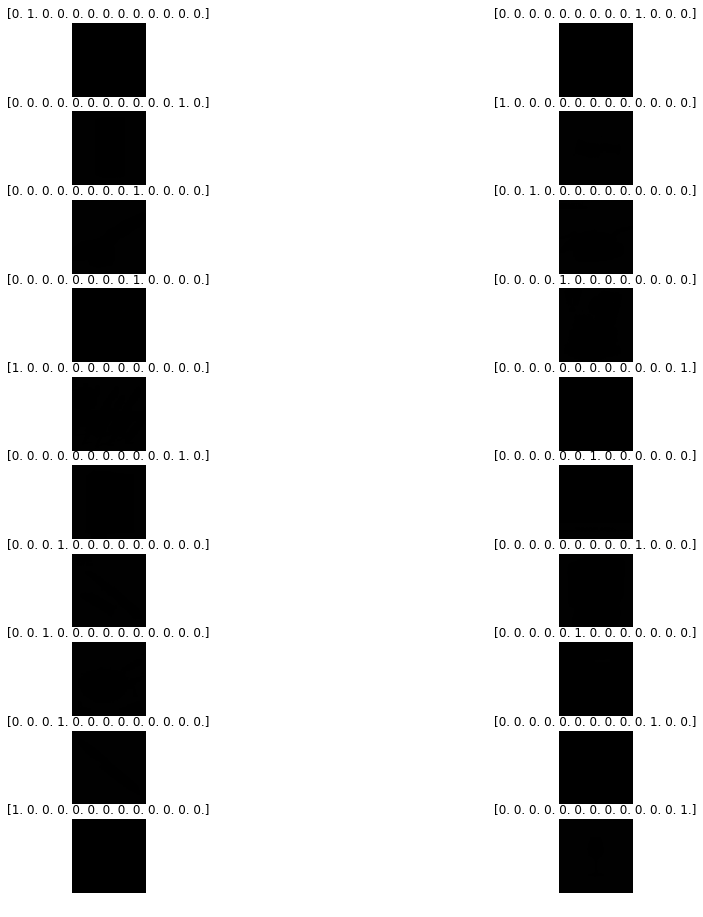

In [10]:
# Batches of 20
plots(imgs, titles = labels)

In [11]:
train_batches.class_indices

{'chopper': 0,
 'clock': 1,
 'frying_pan': 2,
 'knife': 3,
 'massage_chair': 4,
 'microwave': 5,
 'pots': 6,
 'rice_cooker': 7,
 'scissors': 8,
 'stools': 9,
 'swing': 10,
 'wine_cooler': 11,
 'wine_glass': 12}

#### prepare csv to save training logs

In [12]:
# Training with callbacks
from keras import callbacks

filename='training_logs.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)


# filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

# Bulid CNN model

In [13]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))  # no of filter 32# can be 3x3 5x5, 7x7 # input shape 128x128 resolution # 3 RGB
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))  # X no. of filters, 3x3 shape of filters, produces feature maps.
classifier.add(MaxPooling2D(pool_size = (2, 2)))      # takes the max value in matrix, but still retained details, reduces size of matrix

classifier.add(Conv2D(64,(3, 3), activation = 'relu'))  
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Conv2D(64,(3, 3), activation = 'relu'))  
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Dropout(0.5))

classifier.add(Flatten())  # noel... this turns 2d to 1d
classifier.add(Dense(units = 128, activation = 'relu'))  # noel.. this is number of nodes from input.

classifier.add(Dense(units = 13, activation = 'softmax'))  # 13 classes
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
# Viewing model_configuration

classifier.summary()
classifier.get_config()
classifier.layers[0].get_config()
classifier.layers[0].input_shape
classifier.layers[0].output_shape
classifier.layers[0].get_weights()
np.shape(classifier.layers[0].get_weights()[0])
classifier.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
__________

True

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Training starts NOW!!

In [17]:
# steps_per_epoch =  no. of images /  batch_no.
classifier.fit_generator(train_batches, steps_per_epoch = 20, 
                         validation_data = valid_batches, validation_steps = 20, 
                         epochs = 1500, verbose = 2, callbacks=callbacks_list)

Epoch 1/1500
 - 10s - loss: 2.4751 - acc: 0.1400 - val_loss: 2.5334 - val_acc: 0.1300
Epoch 2/1500
 - 7s - loss: 2.4096 - acc: 0.1825 - val_loss: 2.4399 - val_acc: 0.2100
Epoch 3/1500
 - 7s - loss: 2.3174 - acc: 0.2250 - val_loss: 2.3965 - val_acc: 0.2025
Epoch 4/1500
 - 7s - loss: 2.2708 - acc: 0.2375 - val_loss: 2.3831 - val_acc: 0.2325
Epoch 5/1500
 - 8s - loss: 2.2205 - acc: 0.2325 - val_loss: 2.2866 - val_acc: 0.2425
Epoch 6/1500
 - 7s - loss: 2.2588 - acc: 0.2550 - val_loss: 2.2580 - val_acc: 0.2475
Epoch 7/1500
 - 7s - loss: 2.1573 - acc: 0.2675 - val_loss: 2.1867 - val_acc: 0.2725
Epoch 8/1500


/home/ec2-user/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 - 7s - loss: 2.1279 - acc: 0.2750 - val_loss: 2.1498 - val_acc: 0.2525
Epoch 9/1500
 - 7s - loss: 2.1535 - acc: 0.2750 - val_loss: 2.0920 - val_acc: 0.2625
Epoch 10/1500
 - 7s - loss: 1.9846 - acc: 0.3575 - val_loss: 2.0957 - val_acc: 0.2800
Epoch 11/1500
 - 7s - loss: 1.9828 - acc: 0.3500 - val_loss: 2.0357 - val_acc: 0.2850
Epoch 12/1500
 - 7s - loss: 1.9952 - acc: 0.3575 - val_loss: 1.9423 - val_acc: 0.3875
Epoch 13/1500
 - 7s - loss: 2.0373 - acc: 0.3050 - val_loss: 1.9558 - val_acc: 0.3925
Epoch 14/1500
 - 7s - loss: 1.9114 - acc: 0.3700 - val_loss: 1.9423 - val_acc: 0.3350
Epoch 15/1500
 - 7s - loss: 1.8220 - acc: 0.4150 - val_loss: 1.7438 - val_acc: 0.4475
Epoch 16/1500
 - 7s - loss: 1.8134 - acc: 0.3875 - val_loss: 1.8650 - val_acc: 0.4000
Epoch 17/1500
 - 7s - loss: 1.8015 - acc: 0.3975 - val_loss: 1.7842 - val_acc: 0.4075
Epoch 18/1500
 - 7s - loss: 1.6564 - acc: 0.4450 - val_loss: 1.6587 - val_acc: 0.4550
Epoch 19/1500
 - 7s - loss: 1.6938 - acc: 0.4350 - val_loss: 1.7214 -

Epoch 103/1500
 - 12s - loss: 0.9403 - acc: 0.6875 - val_loss: 0.9212 - val_acc: 0.7200
Epoch 104/1500
 - 13s - loss: 0.9641 - acc: 0.7075 - val_loss: 0.8769 - val_acc: 0.7475
Epoch 105/1500
 - 13s - loss: 1.0706 - acc: 0.6875 - val_loss: 0.8846 - val_acc: 0.7200
Epoch 106/1500
 - 13s - loss: 0.9310 - acc: 0.6625 - val_loss: 0.9314 - val_acc: 0.7225
Epoch 107/1500
 - 13s - loss: 0.8972 - acc: 0.6925 - val_loss: 0.9430 - val_acc: 0.7125
Epoch 108/1500
 - 13s - loss: 0.9933 - acc: 0.6700 - val_loss: 0.9531 - val_acc: 0.7125
Epoch 109/1500
 - 13s - loss: 0.9709 - acc: 0.7125 - val_loss: 0.9339 - val_acc: 0.7100
Epoch 110/1500
 - 13s - loss: 0.8834 - acc: 0.7025 - val_loss: 0.8954 - val_acc: 0.7250
Epoch 111/1500
 - 13s - loss: 1.0276 - acc: 0.6875 - val_loss: 0.8677 - val_acc: 0.7375
Epoch 112/1500
 - 13s - loss: 1.0409 - acc: 0.6450 - val_loss: 0.9311 - val_acc: 0.7075
Epoch 113/1500
 - 16s - loss: 0.8574 - acc: 0.7125 - val_loss: 0.9380 - val_acc: 0.7200
Epoch 114/1500
 - 13s - loss: 0.

 - 13s - loss: 0.7728 - acc: 0.7323 - val_loss: 0.7820 - val_acc: 0.7400
Epoch 197/1500
 - 13s - loss: 0.7215 - acc: 0.7500 - val_loss: 0.7786 - val_acc: 0.7450
Epoch 198/1500
 - 13s - loss: 0.7594 - acc: 0.7650 - val_loss: 0.7290 - val_acc: 0.7625
Epoch 199/1500
 - 13s - loss: 0.7465 - acc: 0.7550 - val_loss: 0.7879 - val_acc: 0.7450
Epoch 200/1500
 - 13s - loss: 0.8137 - acc: 0.7375 - val_loss: 0.7599 - val_acc: 0.7425
Epoch 201/1500
 - 13s - loss: 0.7467 - acc: 0.7475 - val_loss: 0.7539 - val_acc: 0.7375
Epoch 202/1500
 - 13s - loss: 0.8025 - acc: 0.7275 - val_loss: 0.7671 - val_acc: 0.7525
Epoch 203/1500
 - 13s - loss: 0.7932 - acc: 0.7425 - val_loss: 0.7810 - val_acc: 0.7475
Epoch 204/1500
 - 13s - loss: 0.8439 - acc: 0.7225 - val_loss: 0.7482 - val_acc: 0.7550
Epoch 205/1500
 - 13s - loss: 0.7676 - acc: 0.7525 - val_loss: 0.7466 - val_acc: 0.7575
Epoch 206/1500
 - 13s - loss: 0.7353 - acc: 0.7525 - val_loss: 0.7530 - val_acc: 0.7450
Epoch 207/1500
 - 13s - loss: 0.7762 - acc: 0.7

Epoch 290/1500
 - 13s - loss: 0.6528 - acc: 0.7850 - val_loss: 0.7106 - val_acc: 0.7750
Epoch 291/1500
 - 13s - loss: 0.6873 - acc: 0.7575 - val_loss: 0.6636 - val_acc: 0.8075
Epoch 292/1500
 - 13s - loss: 0.6693 - acc: 0.7550 - val_loss: 0.6940 - val_acc: 0.7650
Epoch 293/1500
 - 13s - loss: 0.6729 - acc: 0.7700 - val_loss: 0.6950 - val_acc: 0.7825
Epoch 294/1500
 - 13s - loss: 0.7500 - acc: 0.7425 - val_loss: 0.7294 - val_acc: 0.7600
Epoch 295/1500
 - 13s - loss: 0.7133 - acc: 0.7475 - val_loss: 0.7092 - val_acc: 0.7725
Epoch 296/1500
 - 13s - loss: 0.7305 - acc: 0.7500 - val_loss: 0.6773 - val_acc: 0.7875
Epoch 297/1500
 - 13s - loss: 0.7483 - acc: 0.7300 - val_loss: 0.7273 - val_acc: 0.7525
Epoch 298/1500
 - 13s - loss: 0.6438 - acc: 0.7900 - val_loss: 0.7602 - val_acc: 0.7500
Epoch 299/1500
 - 12s - loss: 0.7069 - acc: 0.7750 - val_loss: 0.7271 - val_acc: 0.7650
Epoch 300/1500
 - 14s - loss: 0.7020 - acc: 0.7750 - val_loss: 0.7123 - val_acc: 0.7725
Epoch 301/1500
 - 13s - loss: 0.

 - 13s - loss: 0.6408 - acc: 0.7900 - val_loss: 0.6698 - val_acc: 0.8150
Epoch 384/1500
 - 13s - loss: 0.6423 - acc: 0.7625 - val_loss: 0.6187 - val_acc: 0.8100
Epoch 385/1500
 - 13s - loss: 0.5068 - acc: 0.8325 - val_loss: 0.6355 - val_acc: 0.8025
Epoch 386/1500
 - 13s - loss: 0.6054 - acc: 0.8175 - val_loss: 0.6239 - val_acc: 0.8250
Epoch 387/1500
 - 12s - loss: 0.6068 - acc: 0.7675 - val_loss: 0.7710 - val_acc: 0.7575
Epoch 388/1500
 - 13s - loss: 0.6168 - acc: 0.7800 - val_loss: 0.6653 - val_acc: 0.7900
Epoch 389/1500
 - 13s - loss: 0.6470 - acc: 0.7850 - val_loss: 0.6762 - val_acc: 0.7875
Epoch 390/1500
 - 13s - loss: 0.6419 - acc: 0.7875 - val_loss: 0.6676 - val_acc: 0.7925
Epoch 391/1500
 - 13s - loss: 0.7767 - acc: 0.7525 - val_loss: 0.6724 - val_acc: 0.7875
Epoch 392/1500
 - 13s - loss: 0.7878 - acc: 0.7475 - val_loss: 0.6436 - val_acc: 0.7825
Epoch 393/1500
 - 13s - loss: 0.6035 - acc: 0.7875 - val_loss: 0.6464 - val_acc: 0.7850
Epoch 394/1500
 - 13s - loss: 0.5277 - acc: 0.8

Epoch 477/1500
 - 12s - loss: 0.5867 - acc: 0.8125 - val_loss: 0.5883 - val_acc: 0.7975
Epoch 478/1500
 - 13s - loss: 0.6084 - acc: 0.8025 - val_loss: 0.6224 - val_acc: 0.7975
Epoch 479/1500
 - 13s - loss: 0.5044 - acc: 0.8350 - val_loss: 0.6148 - val_acc: 0.8100
Epoch 480/1500
 - 13s - loss: 0.5470 - acc: 0.8125 - val_loss: 0.6007 - val_acc: 0.7975
Epoch 481/1500
 - 13s - loss: 0.6234 - acc: 0.7775 - val_loss: 0.6000 - val_acc: 0.7975
Epoch 482/1500
 - 13s - loss: 0.6364 - acc: 0.7725 - val_loss: 0.6026 - val_acc: 0.8050
Epoch 483/1500
 - 13s - loss: 0.6241 - acc: 0.7750 - val_loss: 0.5526 - val_acc: 0.8125
Epoch 484/1500
 - 13s - loss: 0.5792 - acc: 0.7900 - val_loss: 0.6531 - val_acc: 0.7975
Epoch 485/1500
 - 13s - loss: 0.6556 - acc: 0.8000 - val_loss: 0.5848 - val_acc: 0.8125
Epoch 486/1500
 - 13s - loss: 0.6091 - acc: 0.7925 - val_loss: 0.5922 - val_acc: 0.7900
Epoch 487/1500
 - 14s - loss: 0.6128 - acc: 0.8200 - val_loss: 0.6356 - val_acc: 0.8075
Epoch 488/1500
 - 13s - loss: 0.

 - 13s - loss: 0.5434 - acc: 0.8150 - val_loss: 0.6268 - val_acc: 0.7875
Epoch 571/1500
 - 13s - loss: 0.5639 - acc: 0.8325 - val_loss: 0.5794 - val_acc: 0.8250
Epoch 572/1500
 - 13s - loss: 0.6367 - acc: 0.7825 - val_loss: 0.5995 - val_acc: 0.8200
Epoch 573/1500
 - 13s - loss: 0.5522 - acc: 0.8400 - val_loss: 0.5781 - val_acc: 0.8150
Epoch 574/1500
 - 13s - loss: 0.5419 - acc: 0.8200 - val_loss: 0.5622 - val_acc: 0.8225
Epoch 575/1500
 - 13s - loss: 0.5771 - acc: 0.8100 - val_loss: 0.6090 - val_acc: 0.7850
Epoch 576/1500
 - 13s - loss: 0.5606 - acc: 0.8350 - val_loss: 0.5830 - val_acc: 0.8050
Epoch 577/1500
 - 13s - loss: 0.5410 - acc: 0.8025 - val_loss: 0.5815 - val_acc: 0.8125
Epoch 578/1500
 - 13s - loss: 0.5127 - acc: 0.8250 - val_loss: 0.5371 - val_acc: 0.8300
Epoch 579/1500
 - 13s - loss: 0.5827 - acc: 0.7975 - val_loss: 0.6029 - val_acc: 0.8175
Epoch 580/1500
 - 13s - loss: 0.5742 - acc: 0.7975 - val_loss: 0.6026 - val_acc: 0.7950
Epoch 581/1500
 - 12s - loss: 0.5981 - acc: 0.7

Epoch 664/1500
 - 13s - loss: 0.5053 - acc: 0.8300 - val_loss: 0.5764 - val_acc: 0.8125
Epoch 665/1500
 - 13s - loss: 0.4595 - acc: 0.8500 - val_loss: 0.5975 - val_acc: 0.8050
Epoch 666/1500
 - 13s - loss: 0.5850 - acc: 0.8075 - val_loss: 0.5909 - val_acc: 0.8200
Epoch 667/1500
 - 13s - loss: 0.6427 - acc: 0.7875 - val_loss: 0.6112 - val_acc: 0.8100
Epoch 668/1500
 - 13s - loss: 0.4990 - acc: 0.8275 - val_loss: 0.6490 - val_acc: 0.8000
Epoch 669/1500
 - 13s - loss: 0.6087 - acc: 0.7900 - val_loss: 0.5916 - val_acc: 0.8125
Epoch 670/1500
 - 13s - loss: 0.5389 - acc: 0.8275 - val_loss: 0.6076 - val_acc: 0.8200
Epoch 671/1500
 - 13s - loss: 0.4171 - acc: 0.8400 - val_loss: 0.5615 - val_acc: 0.8325
Epoch 672/1500
 - 14s - loss: 0.4485 - acc: 0.8375 - val_loss: 0.5778 - val_acc: 0.8175
Epoch 673/1500
 - 13s - loss: 0.5172 - acc: 0.8200 - val_loss: 0.5932 - val_acc: 0.8150
Epoch 674/1500
 - 13s - loss: 0.5434 - acc: 0.8125 - val_loss: 0.5911 - val_acc: 0.8275
Epoch 675/1500
 - 16s - loss: 0.

 - 13s - loss: 0.5447 - acc: 0.8025 - val_loss: 0.5866 - val_acc: 0.8125
Epoch 758/1500
 - 13s - loss: 0.5359 - acc: 0.8100 - val_loss: 0.6480 - val_acc: 0.7900
Epoch 759/1500
 - 13s - loss: 0.5247 - acc: 0.8300 - val_loss: 0.5992 - val_acc: 0.8000
Epoch 760/1500
 - 13s - loss: 0.6083 - acc: 0.7925 - val_loss: 0.5793 - val_acc: 0.8050
Epoch 761/1500
 - 13s - loss: 0.5366 - acc: 0.8225 - val_loss: 0.5362 - val_acc: 0.8275
Epoch 762/1500
 - 13s - loss: 0.5167 - acc: 0.8125 - val_loss: 0.5519 - val_acc: 0.8225
Epoch 763/1500
 - 13s - loss: 0.4720 - acc: 0.8425 - val_loss: 0.6241 - val_acc: 0.8000
Epoch 764/1500
 - 13s - loss: 0.4706 - acc: 0.8450 - val_loss: 0.5836 - val_acc: 0.8200
Epoch 765/1500
 - 13s - loss: 0.4712 - acc: 0.8375 - val_loss: 0.5494 - val_acc: 0.8250
Epoch 766/1500
 - 13s - loss: 0.5303 - acc: 0.8300 - val_loss: 0.5683 - val_acc: 0.8250
Epoch 767/1500
 - 13s - loss: 0.5636 - acc: 0.8125 - val_loss: 0.5749 - val_acc: 0.8225
Epoch 768/1500
 - 13s - loss: 0.4945 - acc: 0.8

Epoch 851/1500
 - 13s - loss: 0.4817 - acc: 0.8325 - val_loss: 0.5854 - val_acc: 0.8150
Epoch 852/1500
 - 13s - loss: 0.5207 - acc: 0.8325 - val_loss: 0.5442 - val_acc: 0.8275
Epoch 853/1500
 - 13s - loss: 0.4661 - acc: 0.8300 - val_loss: 0.6168 - val_acc: 0.8075
Epoch 854/1500
 - 13s - loss: 0.5226 - acc: 0.8200 - val_loss: 0.5528 - val_acc: 0.8175
Epoch 855/1500
 - 13s - loss: 0.4637 - acc: 0.8550 - val_loss: 0.5372 - val_acc: 0.8225
Epoch 856/1500
 - 13s - loss: 0.4254 - acc: 0.8625 - val_loss: 0.5925 - val_acc: 0.8150
Epoch 857/1500
 - 13s - loss: 0.5062 - acc: 0.8075 - val_loss: 0.5670 - val_acc: 0.8275
Epoch 858/1500
 - 13s - loss: 0.4954 - acc: 0.8375 - val_loss: 0.6157 - val_acc: 0.8000
Epoch 859/1500
 - 13s - loss: 0.6264 - acc: 0.7625 - val_loss: 0.6291 - val_acc: 0.8075
Epoch 860/1500
 - 13s - loss: 0.4794 - acc: 0.8225 - val_loss: 0.5717 - val_acc: 0.8250
Epoch 861/1500
 - 13s - loss: 0.5203 - acc: 0.8275 - val_loss: 0.6192 - val_acc: 0.8100
Epoch 862/1500
 - 15s - loss: 0.

 - 13s - loss: 0.4833 - acc: 0.8575 - val_loss: 0.5982 - val_acc: 0.8150
Epoch 945/1500
 - 13s - loss: 0.3928 - acc: 0.8800 - val_loss: 0.5576 - val_acc: 0.8275
Epoch 946/1500
 - 13s - loss: 0.4573 - acc: 0.8450 - val_loss: 0.5398 - val_acc: 0.8300
Epoch 947/1500
 - 13s - loss: 0.4401 - acc: 0.8650 - val_loss: 0.5554 - val_acc: 0.8375
Epoch 948/1500
 - 13s - loss: 0.4522 - acc: 0.8600 - val_loss: 0.5630 - val_acc: 0.8250
Epoch 949/1500
 - 13s - loss: 0.4863 - acc: 0.8400 - val_loss: 0.5636 - val_acc: 0.8175
Epoch 950/1500
 - 13s - loss: 0.5053 - acc: 0.8375 - val_loss: 0.5560 - val_acc: 0.8300
Epoch 951/1500
 - 13s - loss: 0.3206 - acc: 0.9025 - val_loss: 0.5760 - val_acc: 0.8225
Epoch 952/1500
 - 13s - loss: 0.5830 - acc: 0.8300 - val_loss: 0.5957 - val_acc: 0.8150
Epoch 953/1500
 - 13s - loss: 0.4448 - acc: 0.8350 - val_loss: 0.5716 - val_acc: 0.8225
Epoch 954/1500
 - 13s - loss: 0.6031 - acc: 0.7975 - val_loss: 0.5485 - val_acc: 0.8400
Epoch 955/1500
 - 13s - loss: 0.5175 - acc: 0.8

 - 7s - loss: 0.4302 - acc: 0.8575 - val_loss: 0.5896 - val_acc: 0.8150
Epoch 1038/1500
 - 7s - loss: 0.4467 - acc: 0.8575 - val_loss: 0.6264 - val_acc: 0.8100
Epoch 1039/1500
 - 7s - loss: 0.4400 - acc: 0.8525 - val_loss: 0.5716 - val_acc: 0.8150
Epoch 1040/1500
 - 7s - loss: 0.3237 - acc: 0.8850 - val_loss: 0.5617 - val_acc: 0.8250
Epoch 1041/1500
 - 7s - loss: 0.4651 - acc: 0.8375 - val_loss: 0.5936 - val_acc: 0.8225
Epoch 1042/1500
 - 7s - loss: 0.5042 - acc: 0.8150 - val_loss: 0.5725 - val_acc: 0.8275
Epoch 1043/1500
 - 7s - loss: 0.4958 - acc: 0.8325 - val_loss: 0.6031 - val_acc: 0.8250
Epoch 1044/1500
 - 7s - loss: 0.5471 - acc: 0.8300 - val_loss: 0.5145 - val_acc: 0.8375
Epoch 1045/1500
 - 7s - loss: 0.4760 - acc: 0.8300 - val_loss: 0.5705 - val_acc: 0.8275
Epoch 1046/1500
 - 7s - loss: 0.4173 - acc: 0.8650 - val_loss: 0.5454 - val_acc: 0.8300
Epoch 1047/1500
 - 7s - loss: 0.4162 - acc: 0.8650 - val_loss: 0.5748 - val_acc: 0.8150
Epoch 1048/1500
 - 7s - loss: 0.4399 - acc: 0.85

Epoch 1131/1500
 - 7s - loss: 0.4215 - acc: 0.8825 - val_loss: 0.5992 - val_acc: 0.8250
Epoch 1132/1500
 - 7s - loss: 0.4268 - acc: 0.8525 - val_loss: 0.5067 - val_acc: 0.8425
Epoch 1133/1500
 - 7s - loss: 0.5317 - acc: 0.8375 - val_loss: 0.5375 - val_acc: 0.8125
Epoch 1134/1500
 - 7s - loss: 0.4436 - acc: 0.8425 - val_loss: 0.6106 - val_acc: 0.8250
Epoch 1135/1500
 - 7s - loss: 0.4781 - acc: 0.8475 - val_loss: 0.6177 - val_acc: 0.8075
Epoch 1136/1500
 - 7s - loss: 0.3808 - acc: 0.8800 - val_loss: 0.5480 - val_acc: 0.8350
Epoch 1137/1500
 - 7s - loss: 0.4519 - acc: 0.8700 - val_loss: 0.5735 - val_acc: 0.8350
Epoch 1138/1500
 - 7s - loss: 0.4826 - acc: 0.8350 - val_loss: 0.5610 - val_acc: 0.8300
Epoch 1139/1500
 - 7s - loss: 0.4316 - acc: 0.8275 - val_loss: 0.5955 - val_acc: 0.8175
Epoch 1140/1500
 - 7s - loss: 0.5505 - acc: 0.8125 - val_loss: 0.5189 - val_acc: 0.8500
Epoch 1141/1500
 - 7s - loss: 0.3946 - acc: 0.8575 - val_loss: 0.5766 - val_acc: 0.8250
Epoch 1142/1500
 - 7s - loss: 0.

 - 7s - loss: 0.4755 - acc: 0.8352 - val_loss: 0.6048 - val_acc: 0.8175
Epoch 1225/1500
 - 7s - loss: 0.3956 - acc: 0.8600 - val_loss: 0.5667 - val_acc: 0.8275
Epoch 1226/1500
 - 7s - loss: 0.4743 - acc: 0.8675 - val_loss: 0.5734 - val_acc: 0.8275
Epoch 1227/1500
 - 7s - loss: 0.4580 - acc: 0.8400 - val_loss: 0.5557 - val_acc: 0.8275
Epoch 1228/1500
 - 7s - loss: 0.4792 - acc: 0.8575 - val_loss: 0.5102 - val_acc: 0.8375
Epoch 1229/1500
 - 7s - loss: 0.4753 - acc: 0.8550 - val_loss: 0.5142 - val_acc: 0.8300
Epoch 1230/1500
 - 7s - loss: 0.4387 - acc: 0.8800 - val_loss: 0.5198 - val_acc: 0.8275
Epoch 1231/1500
 - 7s - loss: 0.4111 - acc: 0.8675 - val_loss: 0.5107 - val_acc: 0.8300
Epoch 1232/1500
 - 7s - loss: 0.4375 - acc: 0.8375 - val_loss: 0.5085 - val_acc: 0.8500
Epoch 1233/1500
 - 7s - loss: 0.4443 - acc: 0.8600 - val_loss: 0.5541 - val_acc: 0.8200
Epoch 1234/1500
 - 7s - loss: 0.3966 - acc: 0.8800 - val_loss: 0.5265 - val_acc: 0.8225
Epoch 1235/1500
 - 7s - loss: 0.4623 - acc: 0.85

Epoch 1318/1500
 - 7s - loss: 0.4456 - acc: 0.8525 - val_loss: 0.5710 - val_acc: 0.8175
Epoch 1319/1500
 - 7s - loss: 0.4380 - acc: 0.8525 - val_loss: 0.6309 - val_acc: 0.8025
Epoch 1320/1500
 - 7s - loss: 0.3931 - acc: 0.8650 - val_loss: 0.5760 - val_acc: 0.8225
Epoch 1321/1500
 - 7s - loss: 0.3979 - acc: 0.8525 - val_loss: 0.5809 - val_acc: 0.8150
Epoch 1322/1500
 - 7s - loss: 0.3931 - acc: 0.8700 - val_loss: 0.5987 - val_acc: 0.8250
Epoch 1323/1500
 - 7s - loss: 0.4222 - acc: 0.8600 - val_loss: 0.5659 - val_acc: 0.8100
Epoch 1324/1500
 - 7s - loss: 0.5178 - acc: 0.8250 - val_loss: 0.5775 - val_acc: 0.8100
Epoch 1325/1500
 - 7s - loss: 0.4228 - acc: 0.8625 - val_loss: 0.5653 - val_acc: 0.8350
Epoch 1326/1500
 - 7s - loss: 0.3789 - acc: 0.8675 - val_loss: 0.5611 - val_acc: 0.8275
Epoch 1327/1500
 - 7s - loss: 0.4288 - acc: 0.8675 - val_loss: 0.5448 - val_acc: 0.8250
Epoch 1328/1500
 - 7s - loss: 0.3849 - acc: 0.8700 - val_loss: 0.5635 - val_acc: 0.8125
Epoch 1329/1500
 - 7s - loss: 0.

 - 7s - loss: 0.4516 - acc: 0.8475 - val_loss: 0.5545 - val_acc: 0.8275
Epoch 1412/1500
 - 7s - loss: 0.3850 - acc: 0.8775 - val_loss: 0.5595 - val_acc: 0.8350
Epoch 1413/1500
 - 7s - loss: 0.4732 - acc: 0.8275 - val_loss: 0.6145 - val_acc: 0.8100
Epoch 1414/1500
 - 7s - loss: 0.4455 - acc: 0.8675 - val_loss: 0.5490 - val_acc: 0.8375
Epoch 1415/1500
 - 7s - loss: 0.4400 - acc: 0.8451 - val_loss: 0.5439 - val_acc: 0.8275
Epoch 1416/1500
 - 7s - loss: 0.4513 - acc: 0.8550 - val_loss: 0.5312 - val_acc: 0.8400
Epoch 1417/1500
 - 7s - loss: 0.3509 - acc: 0.8650 - val_loss: 0.5896 - val_acc: 0.8175
Epoch 1418/1500
 - 7s - loss: 0.4812 - acc: 0.8425 - val_loss: 0.6313 - val_acc: 0.7825
Epoch 1419/1500
 - 7s - loss: 0.4370 - acc: 0.8525 - val_loss: 0.5439 - val_acc: 0.8450
Epoch 1420/1500
 - 7s - loss: 0.4053 - acc: 0.8550 - val_loss: 0.5651 - val_acc: 0.8125
Epoch 1421/1500
 - 7s - loss: 0.4827 - acc: 0.8225 - val_loss: 0.5257 - val_acc: 0.8325
Epoch 1422/1500
 - 7s - loss: 0.3848 - acc: 0.85

# Save weights and model to a h5 file 

This save functions saves:
    - The architecture of the model, allowing to re-create the model.
    - The weights of themodel.
    - The training configuraton (loss, optimaizer)
    - The state of the optimizer, allowing to resume training exactly where you left off

In [23]:
classifier.save('cnn_model_weights.h5')

In [24]:
model_json = classifier.to_json()
with open("cnn_model.json","w") as json_file:
    json_file.write(model_json)

In [25]:
classifier.save_weights("cnn_weights.h5")

# Prediction

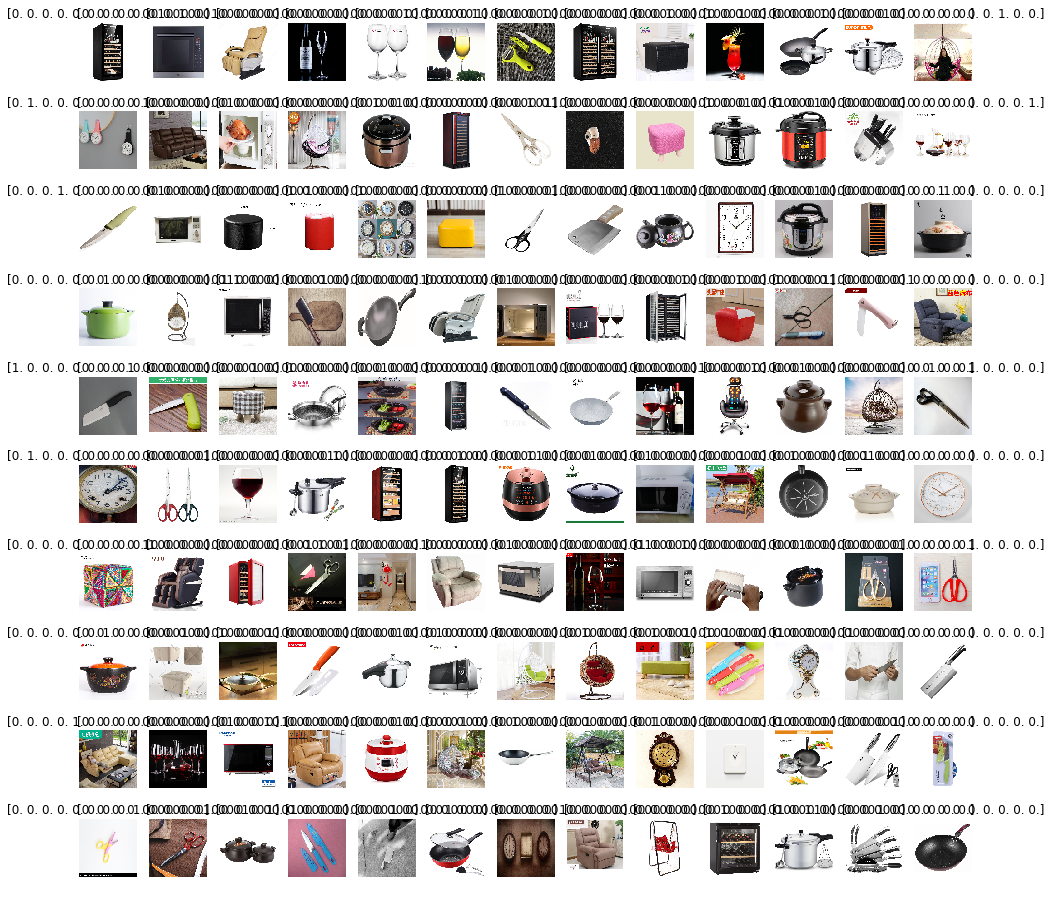

In [26]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [27]:
test_labels_1 = test_labels[:,12]
test_labels_1

array([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [28]:
pred = classifier.predict_generator(test_batches, steps=1, verbose=0)

In [29]:
#checks
len(pred)

130

In [30]:
#checks
np.argmax(pred, axis=1)

array([11,  5,  4,  0, 12, 12,  1, 11,  9,  1,  2, 12,  8,  8,  8, 12, 10,
        1, 11,  8, 12, 12,  7,  7,  8, 12,  3,  5,  7,  7,  1,  1,  8,  0,
        2,  1,  7, 11,  0,  7, 10,  5,  1,  8,  4, 12, 12, 11,  2,  8,  3,
        2,  8,  8, 12,  2,  8, 11,  3,  2, 12,  4,  7, 10,  8,  1,  8, 12,
        7, 11, 11,  1,  2,  2, 10,  1,  2,  1, 10,  4, 11,  3, 12, 12,  5,
       12,  5,  8,  7, 12,  8,  6,  8,  8,  3,  7,  5,  8, 10,  4,  8,  8,
        8,  0,  1, 12,  5,  8,  7, 10,  2,  1,  1, 12,  2,  0,  8,  3,  1,
        2, 12,  8,  2, 10,  8, 10, 11,  7,  8,  2])

In [31]:
# checks
test_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

#### Confusion Matrix

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred, axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[ 3,  1,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  0,  0,  0,  2,  0,  1,  0,  2],
       [ 0,  1,  7,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  1,  0,  4,  0,  0,  0,  0,  3,  0,  0,  0,  2],
       [ 0,  1,  1,  0,  4,  0,  0,  0,  3,  0,  0,  0,  1],
       [ 0,  0,  1,  0,  0,  7,  0,  0,  0,  0,  0,  0,  2],
       [ 1,  0,  4,  0,  0,  0,  1,  3,  1,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  2,  0,  0,  0,  0,  6,  0,  0,  0,  1],
       [ 0,  1,  1,  0,  1,  0,  0,  2,  1,  1,  1,  0,  2],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  2,  0,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8]])

Confusion matrix, without normalization
[[ 3  1  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  2  0  1  0  2]
 [ 0  1  7  0  0  0  0  0  2  0  0  0  0]
 [ 0  1  0  4  0  0  0  0  3  0  0  0  2]
 [ 0  1  1  0  4  0  0  0  3  0  0  0  1]
 [ 0  0  1  0  0  7  0  0  0  0  0  0  2]
 [ 1  0  4  0  0  0  1  3  1  0  0  0  0]
 [ 0  2  0  0  0  0  0  7  0  0  0  0  1]
 [ 0  1  0  2  0  0  0  0  6  0  0  0  1]
 [ 0  1  1  0  1  0  0  2  1  1  1  0  2]
 [ 0  1  0  0  0  0  0  0  2  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  8]]


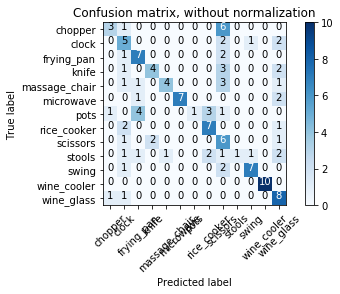

In [33]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                      title='Confusion matrix, without normalization')

#### Classification report

In [34]:
classes=['chopper','clock','frying_pan','knife','massage_chair','microwave', 'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass']
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(pred, axis=1),target_names=classes))

               precision    recall  f1-score   support

      chopper       0.60      0.30      0.40        10
        clock       0.33      0.50      0.40        10
   frying_pan       0.50      0.70      0.58        10
        knife       0.67      0.40      0.50        10
massage_chair       0.80      0.40      0.53        10
    microwave       1.00      0.70      0.82        10
         pots       1.00      0.10      0.18        10
  rice_cooker       0.58      0.70      0.64        10
     scissors       0.23      0.60      0.33        10
       stools       1.00      0.10      0.18        10
        swing       0.78      0.70      0.74        10
  wine_cooler       1.00      1.00      1.00        10
   wine_glass       0.42      0.80      0.55        10

  avg / total       0.69      0.54      0.53       130



#### LIVE Demo image prediction

In [35]:
train_batches.class_indices

{'chopper': 0,
 'clock': 1,
 'frying_pan': 2,
 'knife': 3,
 'massage_chair': 4,
 'microwave': 5,
 'pots': 6,
 'rice_cooker': 7,
 'scissors': 8,
 'stools': 9,
 'swing': 10,
 'wine_cooler': 11,
 'wine_glass': 12}

In [36]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [37]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 128, 128

# load the model we saved
model = load_model('cnn_best_weights.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# predicting images
img = image.load_img('./dataset/test_set/chopper/64236.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)

plots(images, titles=test_labels)
listclass = list(train_batches.class_indices.keys())
print('Predict below item is a : ', listclass[classes[0]])

OSError: Unable to open file (unable to open file: name = 'cnn_best_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)